# Projet python M1

### **Partie 2 : Implémentation et analyse de stratégies d'analyse technique**

Dans cette section, nous allons simuler un investissement de 10 000 000 $ en adoptant deux types de stratégies : passive et active.

- **Stratégie passive** : La totalité des 10 millions sera investie en long sur le S&P 500, avec un réinvestissement systématique des profits réalisés.

- **Stratégie active-passive** : L'investissement sera divisé en deux parts égales. La première moitié (5 millions) sera investie de manière passive, tandis que l'autre moitié sera allouée à des stratégies actives reposant sur l'analyse technique. Ces stratégies seront mises en œuvre, analysées en termes de rendement, puis classées en fonction de leurs performances.

Enfin, nous introduirons et analyserons une stratégie assez différente des précédentes : le pair trading, qui viendra compléter cette comparaison globale.

- #### I. Initialisation
- #### II. Mise en place des stratégies actives
    - 1. SMA
    - 2. Momentum classique
    - 3. Momentum run
    - 4. Bandes de Bollinger
    - 5. RSI
    - 6. Sentiment analysis 
    
- #### III. Analyse des stratégies et backesting généralisé
- #### IV. Une approche différente : le pair trading

### **I. Initialisation**

In [1308]:
import pandas as pd  
import yfinance as yf 
import numpy as np 
import matplotlib.pyplot as plt  
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from statsmodels.tsa.stattools import coint
from math import sqrt
import datetime

import import_ipynb
from Part1_python import stats_desc

In [1309]:
#Demande à l'utilisateur le choix d'une période de backtesting
date_debut = input("Entrez la date de début au format YYYY-MM-DD  (par défaut 2014-01-01) : ") or "2014-01-01"
date_fin=input("Entrez la date de début au format YYYY-MM-DD  (par défaut date d'aujourd'hui) : ") or datetime.date.today()

#Importation des rendements du taux sans risque : T-Bills
rf=yf.download('^IRX ',start=date_debut,end=date_fin)['Adj Close']
rf=rf.squeeze()

#On fixe le capital total
capital = 10000000

[*********************100%***********************]  1 of 1 completed


In [1310]:
#Demande à l'utilisateur le choix du ticker
ticker = input('Veuillez choisir un titre via son ticker : par défaut SPY').upper() or 'SPY'
prix=yf.download(ticker,start=date_debut,end=date_fin)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [1311]:
benchmark=yf.download(ticker,start=date_debut,end=date_fin)['Adj Close']

rdmt_benchmark=benchmark.pct_change().dropna()



[*********************100%***********************]  1 of 1 completed


In [1312]:
#On fixe la partie du capital allouée à la stratégie active et celle allouée à la stratégie passive
cap_passif=capital/2
cap_actif=capital/2

In [1313]:
rdmt_benchmark_cumul=np.cumprod(1+rdmt_benchmark)
x=rdmt_benchmark_cumul*(cap_passif)
passif=rdmt_benchmark_cumul*(capital)

### **II. Mise en place des stratégies actives**

Dans cette section, nous implémenterons **six fonctions correspondant à six stratégies d'investissement** basées sur des indicateurs techniques. Ces stratégies suivent un modèle **Long only/Short only** appliqué à l'actif et à la période sélectionnés par l’utilisateur. Cela signifie que les fonctions renverront une Series avec pour chaque date un **signal d'investissement** (BUY, SELL ou HOLD). Plus précisément, l'entièreté du capital actif sera investi en Long ou en Short selon le premier signal d'investissement. Ensuite, la position sera cloturée une fois le prochain signal atteint. En d'autres termes, deux signaux de même type ne peuvent pas s'enchaîner.

De plus, l'utilisateur peut gérer son exposition à la perte en cas de short via un **coefficient d'aversion** dans la fonction de calcul des profits (partie III). Si la taille de la position perdante devient supérieure à celle du montant fixé, alors **la position Short sera automatiquement clôturée** et l'on repasse en investissement Long.

#### 1. SMA

Cette stratégie repose sur l'utilisation des Simple Moving Average pour générer les signaux d'achats et de vente. Si la moyenne mobile courte (7j) vient dépasser la moyenne mobile longue (30j), alors un signal d'achat est renvoyé, et inversement.

In [1314]:
def sma(rendement):
    #Initialisation de la liste des signaux
    inv=[]

    #Choix de la taille des fenêtres de calcul des moyennes mobiles
    petite_fenetre=7
    longue_fenetre=30

    short_mean=rendement.rolling(petite_fenetre).mean()
    long_mean=rendement.rolling(longue_fenetre).mean()
   
    for i in range(len(rendement)):

        if i > longue_fenetre: # On ne peut pas calculer les moyennes mobiles sur les premières valeurs
            if pd.isna(short_mean.iloc[i].values) or pd.isna(long_mean.iloc[i].values):  # On ignore si les moyennes ne sont pas calculées
                inv.append(None)
            elif short_mean.iloc[i-1].values < long_mean.iloc[i-1].values and short_mean.iloc[i].values > long_mean.iloc[i].values :
                inv.append('BUY')
            elif short_mean.iloc[i-1].values > long_mean.iloc[i-1].values and short_mean.iloc[i].values < long_mean.iloc[i].values:
                inv.append('SELL')
            else:
                inv.append('HOLD')
        else:
            inv.append(None)
        
  
    resultat={
        'actions':pd.Series(inv,index=rendement.index).shift(1), #On décale d'un jour pour lagger les signaux (on dispose des prix close)
        'moyenne courte':short_mean,
        'moyenne longue':long_mean
    }
    return resultat

In [1315]:
filtered_actions = sma(prix)['actions'][
    (sma(prix)['actions'] != 'HOLD') & (sma(prix)['actions'].notnull())
]

filtered_actions.iloc[0]

'SELL'

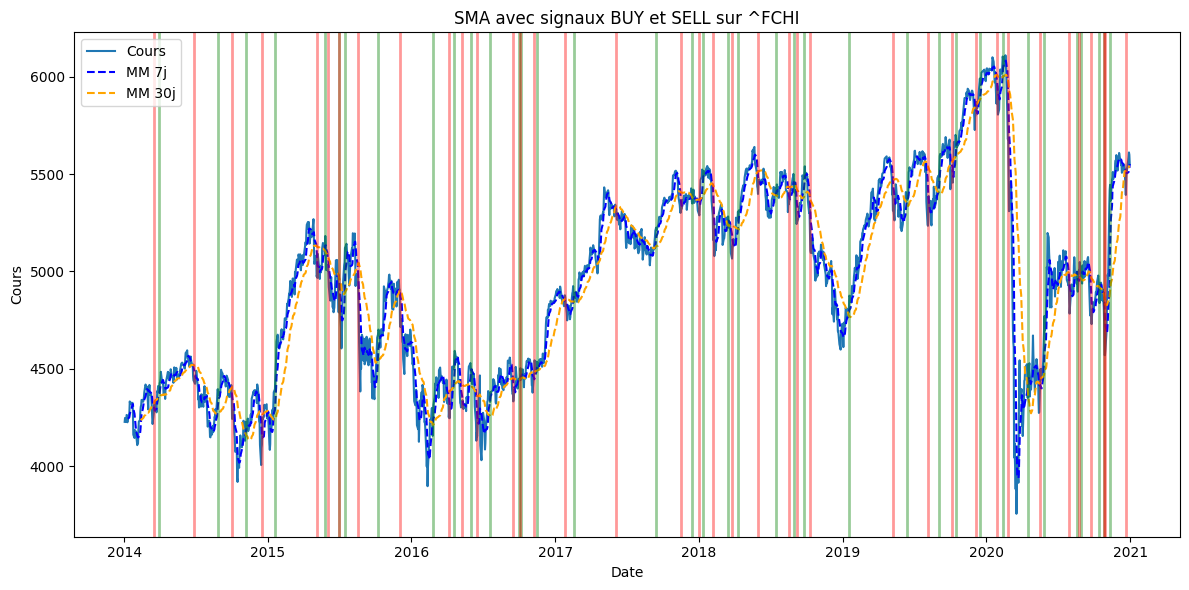

In [1316]:
result = sma(prix)

actions = result['actions']
short_mean = result['moyenne courte']
long_mean = result['moyenne longue']


plt.figure(figsize=(12, 6))
plt.plot(prix, label='Cours')
plt.plot(prix.index, short_mean, label='MM 7j', linestyle='--', color='blue')
plt.plot(prix.index, long_mean, label='MM 30j', linestyle='--', color='orange')

# Filtrer les signaux BUY et SELL
buy_signals = prix[actions == 'BUY']
sell_signals = prix[actions == 'SELL']

for buy in buy_signals.index:
   plt.axvline(x=buy, color='green', linestyle='-', linewidth=2, alpha=0.4)  # Lignes verticales vertes avec opacité réduite
    
for sell in sell_signals.index:
   plt.axvline(x=sell, color='red', linestyle='-', linewidth=2, alpha=0.4)  # Lignes verticales rouges avec opacité réduite


plt.legend()
plt.title(f"SMA avec signaux BUY et SELL sur {ticker}")
plt.xlabel("Date")
plt.ylabel("Cours")
plt.tight_layout()
plt.show()

#### 2. Momentum classique

Cette stratégie s'appuie sur l'un des grands principes de l'analyse technique : suivre la tendance. Elle part du principe que "les actifs qui ont bien performé récemment continueront à bien performer, et ceux qui ont mal performé continueront à sous-performer.". Dans sa version la plus **classique** (car on peut trouver différentes variantes de cette stratégie), on renvoie simplement un signal d'achat si le rendement de l'actif depuis les 2 dernières semaines est positif, et un signal de vente s'il est négatif.

In [1317]:
def momentum_classique(cours, periode:int=14):
    # Initialisation de la liste des signaux
    inv = []

    # Initialisation de la variable de position sur None
    long = None

    # Calcul du momentum
    momentum = cours.pct_change(periode)

    for i in range(len(cours)):
        if pd.isna(momentum.iloc[i].values):  # Ignorer si le momentum n'est pas calculé
            inv.append(None)
        elif momentum.iloc[i].values > 0 and long is not True:  # On ne peut pas acheter si on est déjà long
            inv.append('BUY')
            long = True
        elif momentum.iloc[i].values < 0 and long is not False:  # On ne peut pas vendre à découvert si on est déjà short
            inv.append('SELL')
            long = False
        else:
            inv.append('HOLD')

    return pd.Series(inv, index=cours.index).shift(1) # On décale d'un jour pour lagger les signaux (on dispose des prix close)


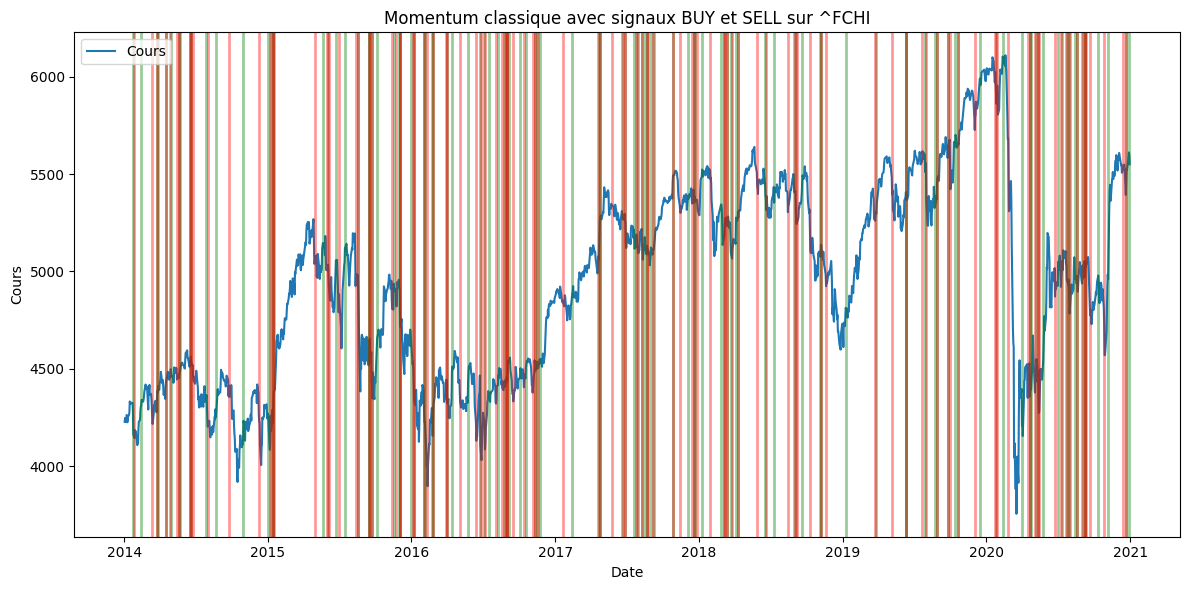

In [1318]:
actions = momentum_classique(prix)

plt.figure(figsize=(12, 6))
plt.plot(prix, label='Cours')

buy_signals = prix[actions == 'BUY']
sell_signals = prix[actions == 'SELL']

for buy in buy_signals.index:
   plt.axvline(x=buy, color='green', linestyle='-', linewidth=2, alpha=0.4)  
    
for sell in sell_signals.index:
   plt.axvline(x=sell, color='red', linestyle='-', linewidth=2, alpha=0.4)  


plt.legend()
plt.title(f"Momentum classique avec signaux BUY et SELL sur {ticker}")
plt.xlabel("Date")
plt.ylabel("Cours")
plt.tight_layout()
plt.show()

#### 3. Momentum run

Autre variante moins utilisée de la stratégie de momentum : le momentum run. Ici, on se base sur le même principe de tendance mais on l'applique différemment. Un signal d'achat est renvoyé si le cours du titre n'a cessé d'augmenter pendant une certaine période (par défaut 4 jours), et inversement avec un signal de vente.

In [1319]:
def momentum_run(cours,seuil:int=4):
    #Initialisation de la liste des signaux
    inv=[]

    #Initialisation des variables de comptage
    nb_hausses=0
    nb_baisses=0

    #Initialisation de la variable de position sur None
    long=None

    for i in range(len(cours)):
        if cours.iloc[i].values>cours.iloc[i-1].values:
            nb_hausses+=1
            nb_baisses=0
        elif cours.iloc[i].values<cours.iloc[i-1].values:
            nb_baisses+=1
            nb_hausses=0
        if nb_hausses>=seuil and long is not True: #On ne peut pas acheter si on est déjà long
            inv.append('BUY')
            nb_hausses=0
            long=True
        elif nb_baisses>=seuil and long is not False: #On ne peut pas vendre à découvert si on est déjà short
            inv.append('SELL')
            nb_baisses=0
            long=False
        else:
            inv.append('HOLD')
    
    return pd.Series(inv,index=cours.index).shift(1) #On décale d'un jour pour lagger les signaux (on dispose des prix close)

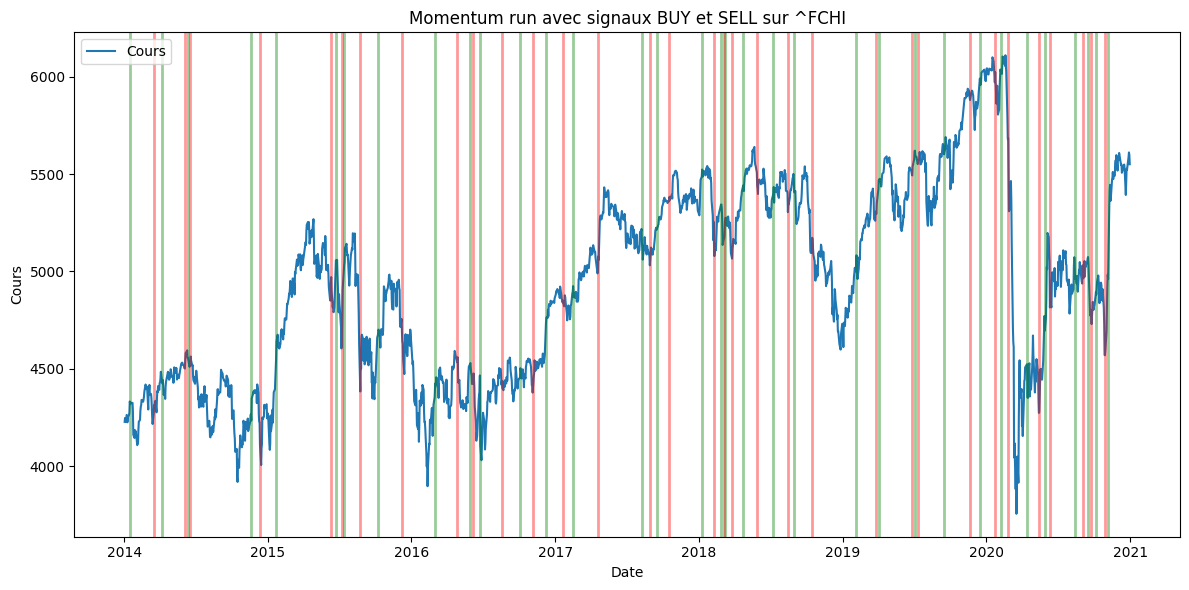

In [1320]:
actions = momentum_run(prix)

plt.figure(figsize=(12, 6))
plt.plot(prix, label='Cours')

buy_signals = prix[actions == 'BUY']
sell_signals = prix[actions == 'SELL']

for buy in buy_signals.index:
   plt.axvline(x=buy, color='green', linestyle='-', linewidth=2, alpha=0.4)  
    
for sell in sell_signals.index:
   plt.axvline(x=sell, color='red', linestyle='-', linewidth=2, alpha=0.4)  


plt.legend()
plt.title(f"Momentum run avec signaux BUY et SELL sur {ticker}")
plt.xlabel("Date")
plt.ylabel("Cours")
plt.tight_layout()
plt.show()

#### 4. Bandes de Bollinger

Assez utilisée par les investisseurs particuliers, la stratégie basée sur les bandes de Bollinger s'appuie sur l'idée que les variations de prix **suivent une distribution proche de la loi normale**. Les bandes sont définies par une moyenne mobile centrale et deux bornes, situées à un certain nombre d'écarts-types (généralement 2) au-dessus et en dessous de cette moyenne. Théoriquement, selon la loi normale, environ 95 % des prix devraient se situer à l'intérieur de ces bornes. Ainsi, lorsque le prix dépasse la bande supérieure, cela peut indiquer un actif potentiellement suracheté (signal de vente), et lorsqu'il descend sous la bande inférieure, il peut être considéré comme survendu (signal d'achat). Cette approche exploite la probabilité de retour des prix vers leur moyenne, tout en tenant compte de la volatilité pour ajuster les seuils dynamiquement.

In [1321]:
def bollinger(rendements,facteur:int =2 ):
    #Initialisation de la liste des signaux
    inv=[]

    #Calcul des moyennes mobiles et des écarts-types mobiles
    mm=rendements.rolling(20).mean()
    std=rendements.rolling(20).std()

    #Initialisation de la variable de position sur None
    long=None
    
    for i in range(len(rendements)):
        #Détermination des bornes supérieures et inférieures à chaque période
        borne_sup=mm.iloc[i-1].values+facteur*std.iloc[i-1].values
        borne_inf=mm.iloc[i-1].values-facteur*std.iloc[i-1].values
        if pd.isna(mm.iloc[i].values):  # Ignorer si les moyennes ne sont pas calculées
            inv.append(None)
        elif rendements.iloc[i-1].values < borne_sup and rendements.iloc[i].values > borne_sup and long is not True : #On ne peut pas acheter si on est déjà long
            inv.append('BUY')
            long=True
        elif rendements.iloc[i-1].values > borne_inf and rendements.iloc[i].values < borne_inf and long is not False : #On ne peut pas vendre à découvert si on est déjà short
            inv.append('SELL')
            long=False
        else:
            inv.append('HOLD')
        
  
    resultat={
        'actions':pd.Series(inv,index=rendements.index).shift(1), #On décale d'un jour pour lagger les signaux (on dispose des prix close)  
        'moyenne mobile':mm,
        'up':mm+facteur*std,
        'down':mm-facteur*std
    }
    return resultat

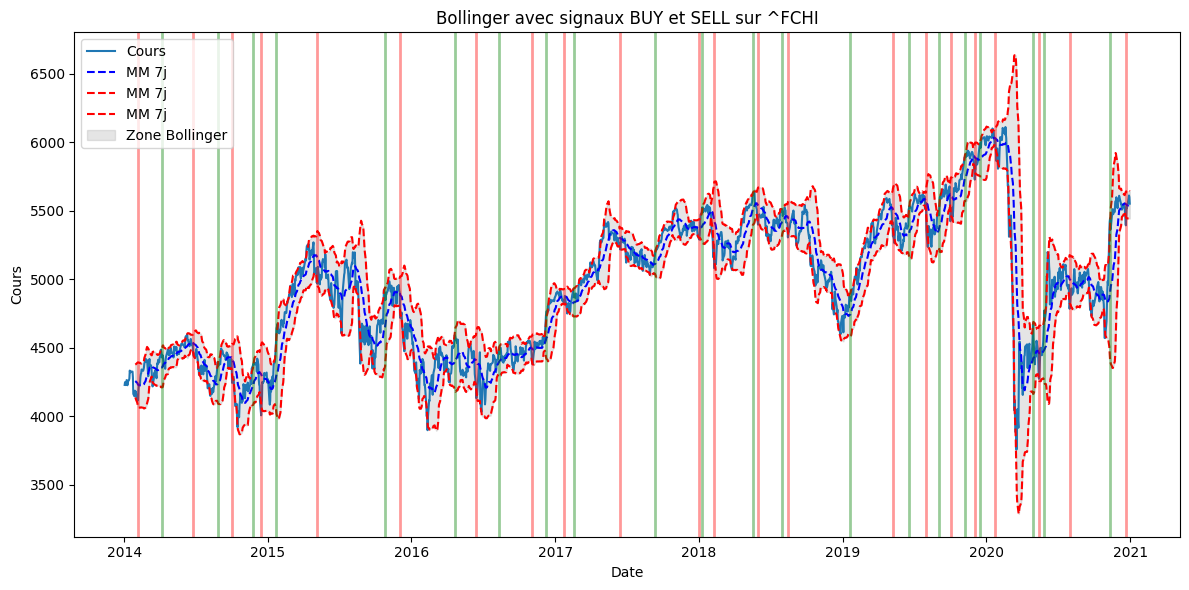

In [1322]:
result = bollinger(prix)

actions = result['actions']
mm = result['moyenne mobile']
up = result['up']
down = result['down']

plt.figure(figsize=(12, 6))
plt.plot(prix, label='Cours')
plt.plot(prix.index, mm, label='MM 7j', linestyle='--', color='blue')
plt.plot(prix.index, up, label='MM 7j', linestyle='--', color='red')
plt.plot(prix.index, down, label='MM 7j', linestyle='--', color='red')


buy_signals = prix[actions == 'BUY']
sell_signals = prix[actions == 'SELL']

for buy in buy_signals.index:
   plt.axvline(x=buy, color='green', linestyle='-', linewidth=2, alpha=0.4)  # Lignes verticales vertes avec opacité réduite
    
for sell in sell_signals.index:
   plt.axvline(x=sell, color='red', linestyle='-', linewidth=2, alpha=0.4)  # Lignes verticales rouges avec opacité réduite


# Mise en évidence de la zone Bollinger
plt.fill_between(
    mm.index,
    down.squeeze(),
    up.squeeze(),
    color='gray',
    alpha=0.2,
    label='Zone Bollinger'
)

plt.legend()
plt.title(f"Bollinger avec signaux BUY et SELL sur {ticker}")
plt.xlabel("Date")
plt.ylabel("Cours")
plt.tight_layout()
plt.show()

#### 5. RSI

Le Relative Strenght Indice, également assez utilisé par les traders particuliers, est un oscillateur borné entre 0 et 100. Son calcul repose sur l’évaluation de la force et de la vitesse des mouvements de prix récents pour détecter des situations de surachat ou de survente.

$$RSI = 100 - \frac{100}{1 + RS}$$

où $RS = \frac{\text{Moyenne des gains sur } n \text{ périodes}}{\text{|Moyenne des pertes sur } n \text{ périodes|}}$

Théoriquement, un actif est considéré comme suracheté lorsque le RSI dépasse 70, suggérant une possible correction à la baisse (signal de vente), et survendu lorsqu’il descend sous 30, indiquant un potentiel rebond à la hausse (signal d'achat). Cette stratégie exploite les excès émotionnels du marché, en anticipant une réversion vers des niveaux plus équilibrés.

In [1323]:
def rsi(cours,fenetre:int=14):
    #Initialisation de la liste des signaux
    inv=[]

    #Initialisation de la variable de position sur None
    long=None

    #Calcul des rendements
    rdmt=cours.pct_change().dropna()

    #Calcul des gains et des pertes moyennes dans la fenêtre
    gains = rdmt.clip(lower=0).rolling(window=fenetre).mean()
    pertes = -rdmt.clip(upper=0).rolling(window=fenetre).mean()
    
    #Calcul du RSI
    ratio=gains/abs(pertes)
    rsi=100-(100/(1+ratio))

    for i in range(len(rdmt)):

        if pd.isna(rsi.iloc[i].values):  # Ignorer si les moyennes ne sont pas calculées
            inv.append(None)
        elif rsi.iloc[i].values < 30 and rsi.iloc[i].values>0 and long is not True: #On ne peut pas acheter si on est déjà long
            inv.append('BUY')
            long=True
        elif rsi.iloc[i].values > 70 and long is not False: #On ne peut pas vendre à découvert si on est déjà short
            inv.append('SELL')
            long=False
        else:
            inv.append('HOLD')

    
    resultat= {'RSI':rsi,'signaux':pd.Series(inv,index=rdmt.index).shift(1)} #On décale d'un jour pour lagger les signaux (on dispose des prix close)
    
    return resultat

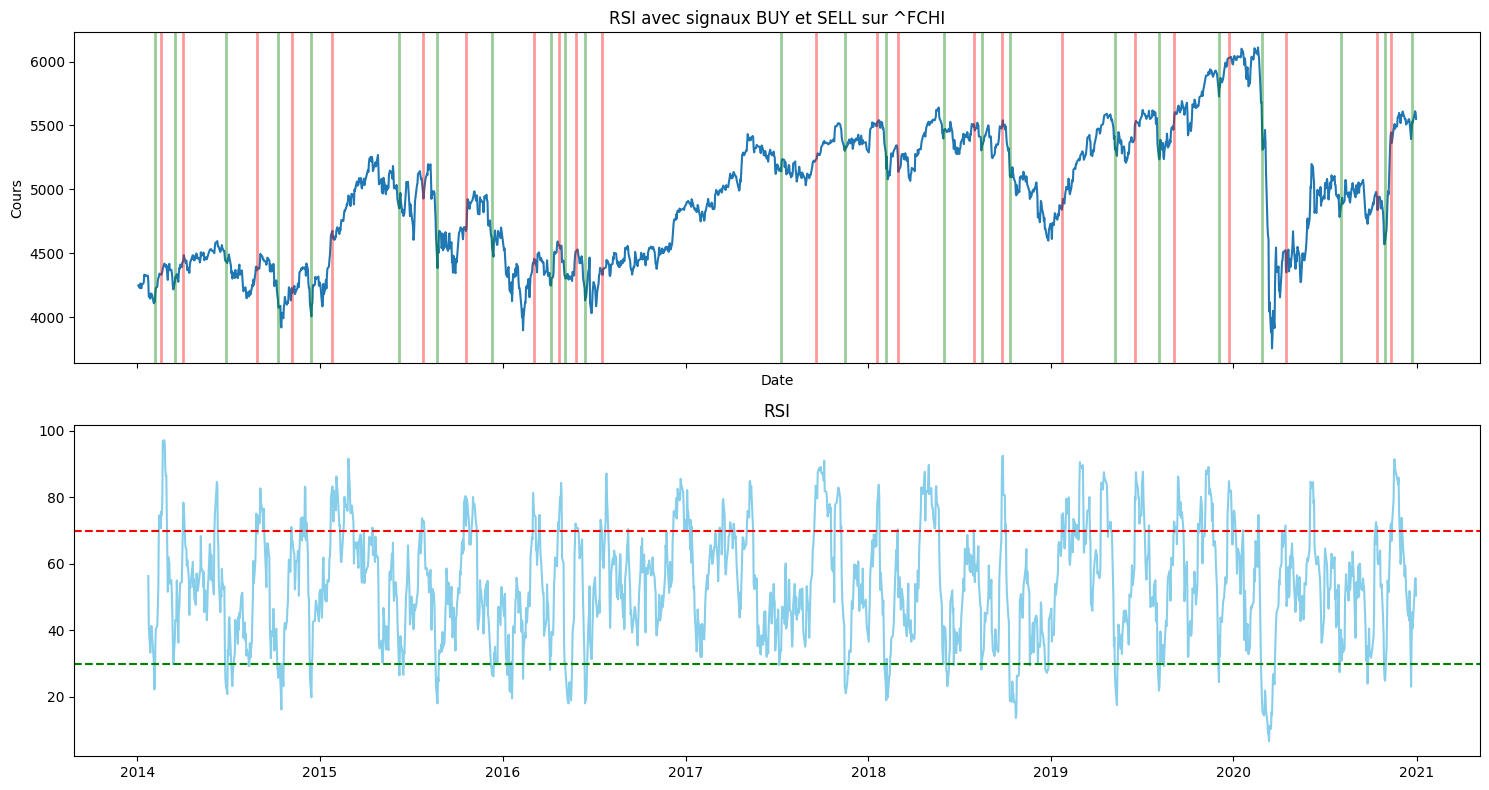

In [1324]:
result = rsi(prix)

# Affichage des signaux d'achats/ventes et du RSI
fig, axes = plt.subplots(2, 1, figsize=(15, 8),sharex=True)

prix=prix[1:]
actions = result['signaux']

axes[0].plot(prix, label='Cours')

buy_signals = prix[actions == 'BUY']
sell_signals = prix[actions == 'SELL']

for buy in buy_signals.index:
   axes[0].axvline(x=buy, color='green', linestyle='-', linewidth=2, alpha=0.4)  # Lignes verticales vertes avec opacité réduite
    
for sell in sell_signals.index:
   axes[0].axvline(x=sell, color='red', linestyle='-', linewidth=2, alpha=0.4)  # Lignes verticales rouges avec opacité réduite


axes[0].set_title(f"RSI avec signaux BUY et SELL sur {ticker}")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cours")

# Tracé du RSI
axes[1].plot(rsi(prix)['RSI'], label='Cours',color='skyblue')
# Lignes horizontales pour les seuils (verts achat et rouge vente)
axes[1].axhline(70, color='red', linestyle='--', label='Seuil superieur')
axes[1].axhline(30, color='green', linestyle='--', label='Seuil inferieur')
axes[1].set_title("RSI")

plt.tight_layout()
plt.show()

#### 6. Sentiment analysis

Pour clôturer cette partie, nous passons à une stratégie d'investissement différente et bien moins utilisée par les particuliers : l'analyse sentimentale. L'analyse sentimentale essaie de mesurer des émotions exprimées dans des données textuelles en renvoyant un indicateur compris entre -1 et 1. Plus l'indicateur est proche de -1, plus les émotions dégagées du textes sont mesurées comme négatives, plus il est proche de 1, plus elles sont perçues comme positives.

Pour la mise en place de cette stratégie, on s'appuie sur une bibliotèque d'analyse sentimentale déjà existante : VaderSentiment. On appliquera alors sa fonction d'analyse sur l'ensemble des tweets publiés par D. Trump entre 2009 et début 2021.

In [1325]:
#Chargement de la classe SentimentIntensityAnalyzer
SentimentAnalyser=SentimentIntensityAnalyzer()

#Importation de la base de données
trump_df=pd.read_csv('/Users/tristan/Desktop/Python M1 2024/Séance 6/Trump-Tweets_2009-2021.csv')

#Suppresion des colonnes non pertinentes
trump_df=trump_df.drop(['id','device','isRetweet'],axis='columns')

Afin d'appliquer plus facilement les foncitonnalités de VaderSentiment, on crée directement une courte fonction retournant le score d'intensité sentimentale d'un texte.

In [1326]:
def calculate_sentiment(text):
    
    # Execution de VADER sur le texte
    scores=SentimentAnalyser.polarity_scores(text)

    # Extraction du compound score
    compound_score=scores['compound']
    
    return compound_score

In [1327]:
#Calcul du score de sentiment pour chaque tweet
trump_df['sentiment_score']=trump_df['text'].apply(calculate_sentiment)

#Tri des tweets par score de sentiment
trump_df.sort_values(by='sentiment_score',ascending=False)

,text,isDeleted,favorites,retweets,date,isFlagged,sentiment_score
23169,Congratulations to Patrick Reed on his great a...,f,79374,10122,4/9/18 0:43,f,0.9899
7200,I am a big fan of Drew Brees. I think he’s tru...,f,267196,48513,6/5/20 20:08,f,0.9879
5169,"Today, it was my great honor to proudly accept...",f,86425,22183,8/15/20 3:59,f,0.9879
2490,It was great to be back in North Carolina with...,f,46024,10955,10/15/20 19:20,f,0.9876
11615,95% Approval Rating in the Republican Party. T...,f,110818,23498,1/26/20 16:24,f,0.9869
...,...,...,...,...,...,...,...
21818,The Rigged Russian Witch Hunt goes on and on a...,f,66924,15264,8/15/18 14:08,f,-0.9785
7096,Colin Powell was a pathetic interview today on...,f,127934,28175,6/8/20 3:42,f,-0.9800
1552,Our prayers are with the people of Vienna afte...,f,236684,39564,11/3/20 4:25,f,-0.9810
21749,It is outrageous that Poisonous Synthetic Hero...,f,89183,23153,8/20/18 17:14,f,-0.9825


In [1328]:
#Conversion de la colonne date en datetime
trump_df['date']=pd.to_datetime(trump_df['date'], format='%m/%d/%y %H:%M')
#Mise en index de la colonne date
trump_df=trump_df.set_index(['date'])

Puisque nous avons des données journalières, nous devons agréger les tweets par jour pour obtenir un score moyen de sentiment journalier.

In [1329]:
trump_df_daily=trump_df.resample('D')['sentiment_score'].mean()

In [1330]:
trump_df_daily=pd.DataFrame(trump_df_daily).dropna()
display(trump_df_daily)

,sentiment_score
date,
2009-05-04,0.525500
2009-05-05,0.771200
2009-05-08,0.323400
2009-05-12,0.240450
2009-05-13,0.750600
...,...
2021-01-03,0.081393
2021-01-04,0.094536
2021-01-05,0.116500


On définit ensuite la fonction d'investissement avec un seuil à partir duquel les signaux d'investissement seront renvoyés.

In [1331]:
def sentiment(score,seuil:float=0.2):
    #Initialisation de la liste des signaux
    inv = []

    #Initialisation de la variable de position sur None
    long=None

    for i in range(len(score)):
        if score.iloc[i].values > seuil and long is not True: #On ne peut pas acheter si on est déjà long
            inv.append("BUY")
            long=True
        elif score.iloc[i].values < -seuil and long is not False: #On ne peut pas vendre à découvert si on est déjà short
            inv.append( "SELL")
            long=False
        else:
            inv.append( "HOLD")

    inv=pd.Series(inv,index=score.index).shift(1) #On décale d'un jour pour lagger les signaux (on dispose des prix close)
    return inv

### **III. Analyse des stratégies et backesting généralisé**

Pour analyser l'efficacité de chaque stratégie, il est nécessaire en premier lieu de créer une fonction permettant d'interpréter leurs signaux d'investissement renvoyés. Pour cela, on aurait pu simplement passer par *(np.cumprod()+1)* et ensuite ajuster selon qu'on soit short ou long. Mais cette méthode ne permet pas de prendre en compte le mécanisme de fermeture de la position short selon l'aversion de l'utilisateur. C'est pour cette raison qu'une fonction nommée *profit_actif*, prenant en argument les cours du titre, la liste de signaux d'investissement, le capital de départ et le coefficient d'aversion, a été mise en place.

Cette fonction détermine tout d'abord avec une première boucle si l'on va Long ou Short. En fonction du premier signal d'investissement, le booléen VAD (Vente à Découvert) va prendre la valeur True ou False. Si l'on Long, alors VAD=False et on se dirige donc vers la dernière boucle qui calcule simplement l'évolution du capital. Si l'on Short, on intègre la boucle où VAD=True. Dans celle-ci, on calcule également l'évolution du capital (mais en short) mais l'on vérifie également que le seuil de protection du capital n'ai pas été franchi. Si oui, le booléen VAD passe en False et la boucle est quittée automatiquement (fermeture de la positon). On intègre donc ensuite la boucle Long mais directement à la période i pour terminer en position Long.

La fonction retourne un DataFrame avec pour chaque date la valeur mise à jour du capital.

In [1332]:
def profit_actif(cours, position,capital:float,aversion:int=4):

    #On crée un DataFrame avec les positions et les cours
    position.name='action'
    df=pd.concat([position,cours],axis=1).dropna()

    #Initialisation de la liste des rendements
    rdmt=[]

    #Initialisation des variables d'investissement
    invest=None
    VAD=None
    transition = False

    #Déclaration de i = 0 au cas où l'on quitterait la boucle de VAD avant la fin 
    i=0

    #Gère le cas où la stratégie Sentiment ne donne aucun signal (hors 2016-2021)
    if df['action'].isnull().all():
        rdmt=pd.DataFrame(rdmt,columns=['capital'],index=df.index)
        return rdmt

    #Détermination de la première action : si l'on va être long ou short pour le reste de la période
    VAD=False if df['action'][(df['action'] != 'HOLD')].iloc[0] == 'BUY' else True

    #Boucle si l'on short
    if VAD==True:
        for i in range(len(df)):
            #Fermeture de la position short
            if df['action'].iloc[i]=='BUY':
                invest=True
                capital *= (df[ticker].iloc[i - 1] / df[ticker].iloc[i])
            
            #Ouverture de la position short
            elif df['action'].iloc[i]=='SELL':
                invest = False
                cours_short=df[ticker].iloc[i]
                qte=capital/cours_short
            
            else:
                #Calcul du rendement si l'on est short (sinon cela veut dire que l'on est pas investi)
                if invest==False:
                    #Verification de la condition de protection du capital
                    if qte*(df[ticker].iloc[i]-cours_short) > capital/aversion:
                        capital *= (df[ticker].iloc[i-1] / df[ticker].iloc[i])
                        VAD=False
                        transition = True
                        break
                    else:
                        capital *= (df[ticker].iloc[i-1] / df[ticker].iloc[i])
      
            if transition==True:
            # Ici, on commence l'autre boucle (le cas où VAD == False)
                break 
            rdmt.append(capital)

    #Boucle si l'on long (directement ou après avoir quitté la boucle précédente)
    if VAD==False:
        for j in range(i,len(df)):
            #Ouverture de la position long
            if df['action'].iloc[j]=='BUY':
                qte = capital / df[ticker].iloc[j]
                invest=True

            #Fermeture de la position long
            elif df['action'].iloc[j]=='SELL':
                capital = qte * df[ticker].iloc[j]
                invest = False

            else:
                #Calcul du rendement si l'on est long (sinon cela veut dire que l'on est pas investi)
                if invest==True:
                    capital *= (df[ticker].iloc[j] / df[ticker].iloc[j-1])
            rdmt.append(capital)

    #On retourne la liste de l'évolution du capital
    rdmt=pd.DataFrame(rdmt,columns=['capital'],index=df.index)
    return rdmt

On peut ensuite appliquer la fonction à chaque stratégie d'investissement et déterminer comment le capital acitf évolue dans chacune d'entre elles. On pourra alors combiner ce résultat avec celui du capital passif pour obtenir le résultat final de chaque stratégie d'investissement actif-passif.

In [1333]:
momentum_classic_strat=profit_actif(prix,momentum_classique(prix),cap_actif)['capital']+x[ticker]
momentum_run_strat=profit_actif(prix,momentum_run(prix),cap_actif)['capital']+x[ticker]
sma_strat=profit_actif(prix,sma(prix)['actions'],cap_actif)['capital']+x[ticker]
bollinger_strat=profit_actif(prix,bollinger(prix,2)['actions'],cap_actif)['capital']+x[ticker]
sentiment_strat=profit_actif(prix,sentiment(trump_df_daily),cap_actif)['capital']+x[ticker]
rsi_strat=profit_actif(prix,rsi(prix)['signaux'],cap_actif)['capital']+x[ticker]

#Creation du DataFrame regroupant l'evolution du capital pour chaque strategie
strategies=pd.concat([momentum_classic_strat,momentum_run_strat,sma_strat,bollinger_strat,rsi_strat,sentiment_strat],axis=1)
strategies.columns = ['Momentum classique','Momentum run', 'SMA', 'Bollinger', 'RSI','Sentiment']

In [1334]:
#On supprime la stratégie Sentiment si elle ne contient que des NaN (après debut 2021)
if sentiment_strat.isna().all():
    strategies.drop('Sentiment',axis=1,inplace=True)


strategies_filled = strategies
strategies_filled['Benchmark'] = passif

#On change le backend de pandas pour afficher les graphiques avec Plotly
pd.options.plotting.backend = "plotly"
strategies_filled.plot(title=f'Comparaison des différentes stratégies sur {ticker}',labels=dict(value='Capital',index='Date'))

Enfin, on peut calculer les rendements de chaque stratégie à partir des résultats précédents.

In [1335]:
momentum_classique_bt=momentum_classic_strat.pct_change(fill_method=None)
momentum_run_bt=momentum_run_strat.pct_change(fill_method=None)
sma_bt=sma_strat.pct_change(fill_method=None)
bollinger_bt=bollinger_strat.pct_change(fill_method=None)
sentiment_bt=sentiment_strat.pct_change(fill_method=None)
rsi_bt=rsi_strat.pct_change(fill_method=None)

#Creation du DataFrame regroupant les rendements de chaque strategie
strategies_bt=pd.concat([momentum_classique_bt,momentum_run_bt,sma_bt,bollinger_bt,rsi_bt,sentiment_bt],axis=1)
strategies_bt.columns = ['Momentum classique','Momentum run', 'SMA', 'Bollinger', 'RSI','Sentiment']

Grâce à la fonction *stats_desc* de la Partie 1, on peut décrire directement les rendements de chaque stratégie pour l'actif et la période choisie par l'utilisateur.

In [1336]:
stats_desc(strategies_bt).round(3)

,mean,max,min,std,skew,kurt
Momentum classique,0.0,0.076,-0.071,0.009,-0.312,7.454
Momentum run,0.0,0.076,-0.080,0.010,-0.778,9.817
SMA,0.0,0.028,-0.028,0.004,-0.561,6.791
Bollinger,-0.0,0.026,-0.029,0.004,-0.454,7.317
RSI,0.0,0.084,-0.123,0.010,-1.141,22.836
Sentiment,0.0,0.084,-0.123,0.012,-0.905,12.578


Puisque l'on dispose des rendements de chaque stratégie ainsi que des rendements de l'actif sans risque, on peut calculer plusieurs **ratios de performance** (Sharpe, Sortino, Calmar) ainsi que la VaR et cVaR historique à 95%.

In [1265]:
def sharpe(capital,rf):
    #On convertit le taux sans risque qui était en pourcentage
    rf=rf/100
    #On calcule les rendements journaliers
    rdmt=capital.pct_change(fill_method=None).dropna()
    #Evite les erreurs si la liste est vide
    if len(rdmt)==0:
        return 
    rdmt_rf=rf.pct_change().dropna()
    #On calcule le rendement annuel du taux sans risque
    rf_annuel=rf.mean()
    #On calcule l'écart-type annuel
    std_annuel=rdmt.std()*sqrt(365)
    
    #On calcule le rendement annuel
    rdmt_annuel= (np.prod(rdmt + 1,axis=0))**(365 / len(rdmt)) - 1
    
    sharpe =  (rdmt_annuel - rf_annuel)/ std_annuel  
    return float(sharpe)

In [1266]:
def sortino(capital,rf):
    #On convertit le taux sans risque qui était en pourcentage
    rf=rf/100
    #On calcule les rendements journaliers
    rdmt=capital.pct_change(fill_method=None).dropna()
    #Evite les erreurs si la liste est vide
    if len(rdmt)==0:
        return 
    #Calcul de l'écart-type annuel des rendements négatifs
    rdmt_neg=rdmt[rdmt<0]
    std_annuel=rdmt_neg.std()*sqrt(365)

    #Calcul du rendement annuel du taux sans risque
    rf_annuel=rf.mean()
    
    #Calcul du rendement annuel
    rdmt_annuel= (np.prod(rdmt + 1,axis=0))**(365 / len(rdmt)) - 1
    
    sortino =  (rdmt_annuel - rf_annuel)/ std_annuel  
    return float(sortino)

In [1267]:
def calmar(capital,rf):
    #On convertit le taux sans risque qui était en pourcentage
    rf=rf/100
    #On calcule les rendements journaliers
    rdmt=capital.pct_change(fill_method=None).dropna()
    #Evite les erreurs si la liste est vide
    if len(rdmt)==0:
        return 
    #Calcul du rendement cumulé 
    rdmt_cum=np.cumprod(rdmt+1)
    #Calcul du rendement annuel du taux sans risque
    rf_annuel=rf.mean()
    HWM=rdmt_cum.expanding().max()  #Détermine la valeur maximale du portefeuille jusqu'à chaque point dans le temps, ce qui aide à identifier les pics avant les drawdowns.
    rendement_annuel = np.prod(rdmt+1,axis=0)**(365/len(rdmt))-1
    drawdown=(rdmt_cum-HWM)/HWM   #Calcule le drawdown comme la baisse relative depuis le dernier pic.

    return (rendement_annuel - rf_annuel)/-np.min(drawdown)

In [1268]:
def var(capital):
    #Calcul des rendements journaliers
    rdmt=capital.pct_change(fill_method=None).dropna()
    #Evite les erreurs si la liste est vide
    if len(rdmt)==0:
           return
    #Détermination de la VaR et CVaR historique à 95%
    var=np.percentile(rdmt,5)
    cvar=np.mean(rdmt[rdmt<=var])
    
    return var,cvar

Il suffit finalement d'agréger l'ensemble de ces indicateurs pour avoir en un seul DataFrame la description complète des rendements.

In [1337]:
def analyse(df,rf,df_benchmark):

    #Calcul des rendements du benchmark puis du capital passif pour déterminer le surplus dégagé
    rdmt_benchmark=df_benchmark.pct_change().dropna()
    rdmt_benchmark_cumul=np.cumprod(1+rdmt_benchmark)
    passif=rdmt_benchmark_cumul*(capital)

    analyse={
        'Sharpe':[sharpe(df[strat],rf) for strat in df.columns],
        'Sortino':[sortino(df[strat],rf) for strat in df.columns],
        'Calmar':[calmar(df[strat],rf) for strat in df.columns],
        'VaR': [var(df[strat])[0] if var(df[strat]) is not None else None for strat in df.columns],
        'cVaR': [var(df[strat])[1] if var(df[strat]) is not None else None for strat in df.columns],
        'surplus dégagé': [(df[strat].iloc[-1]-passif.iloc[-1]).item() for strat in df.columns]
    }

    analyse=pd.DataFrame(analyse,index=df.columns)
    return analyse

En appliquant cette fonction d'analyse aux résultats des stratégies sur le CAC40 pendant la période 2014-2021 (2021 étant l'année où s'arrête notre base de tweets de D. Trump), on remarque ques les ratios de performances des stratégies sont mauvais et que seul la stratégie de RSI bat le benchmark. 

In [1338]:
analyse(strategies,rf,benchmark).round(3)

,Sharpe,Sortino,Calmar,VaR,cVaR,surplus dégagé
Momentum classique,0.085,0.108,0.050,-0.015,-0.023,-2049035.432
Momentum run,-0.011,-0.013,-0.007,-0.015,-0.024,-2835521.085
SMA,-0.111,-0.130,-0.065,-0.007,-0.012,-3079375.108
Bollinger,-0.158,-0.190,-0.102,-0.006,-0.011,-3404456.093
RSI,0.428,0.488,0.235,-0.014,-0.025,2105862.390
Sentiment,0.197,0.239,0.113,-0.017,-0.029,-151257.834
Benchmark,0.203,0.251,0.125,-0.018,-0.030,0.000


Toutes les analyses précédentes reposent sur l'actif choisi par l'utilisateur à travers son ticker. En conséquence, les performances de chaque stratégie peuvent varier considérablement en fonction du titre sélectionné. On remarque que lorsque le titre choisi a bien performé durant la période, les stratégies actives ont tendance à sous-performer le benchmark, et inversement.

Afin d'évaluer plus fiablement ces stratégies, nous procédons désormais à un **backtesting généralisé**. L'objectif est cette fois de sélectionner un ensemble de tickers et d'appliquer les analyses précédentes à chacun d'eux. Cela nous permettra de créer un DataFrame global à partir duquel nous pourrons déterminer la moyenne des performances pour l'ensemble des actifs. 

Plus le nombre de tickers sélectionnés est élevé, plus l'analyse sera précise, bien que cela entraîne également une augmentation du temps d'exécution.

In [1271]:
date_debut='2016-01-01'
date_fin='2020-12-31'
date_fin=datetime.date.today()
euro_stoxx_50_tickers = [
    'ADS.DE', 'AIR.PA', 'ALV.DE', 'ABI.BR', 'ASML.AS', 'AI.PA', 'BAS.DE', 'BAYN.DE', 'BBVA.MC', 'SAN.MC',
    'BNP.PA', 'ENEL.MI', 'ENI.MI', 'EL.PA', 'IBE.MC', 'ISP.MI', 'OR.PA', 'MC.PA', 'MUV2.DE', 'NESN.S',
    'PHIA.AS', 'RDSA.AS', 'SAP.DE', 'SIE.DE', 'SU.PA', 'TEF.MC', 'TOTF.PA', 'ULVR.L', 'VOW3.DE', 'ZURN.S',
    'CS.PA', 'SGO.PA', 'DG.PA', 'BN.PA', 'KER.PA', 'RI.PA', 'SAF.PA', 'STM.PA', 'VIV.PA', 'WLN.PA',
    'DTE.DE', 'FME.DE', 'LIN.DE', 'SIKA.S', 'AD.AS', 'INGA.AS', 'KPN.AS', 'MT.AS', 'UNA.AS', 'HEIA.AS'
]
SP100_tickers= 'AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'FB', 'TSLA', 'BRK.B', 'NVDA', 'V', 'JPM', 'JNJ', 'PYPL', 'DIS', 'HD', 'MA', 'NFLX', 'BA', 'WMT', 'PG', 'UNH', 'INTC', 'XOM', 'CSCO', 'VZ', 'PFE', 'ADBE', 'KO', 'MRK', 'IBM', 'CVX', 'T', 'MS', 'ABT', 'RTX', 'LMT', 'NEE', 'NKE', 'MCD', 'AMGN', 'INTU', 'GS', 'UPS', 'COST', 'CAT', 'ORCL', 'QCOM', 'TXN', 'MMM', 'GE', 'AXP', 'LOW', 'MDT', 'SBUX', 'SPG', 'TMO', 'FIS', 'ISRG', 'WBA', 'BMY', 'SYK', 'DE', 'SCHW', 'BLK', 'COP', 'TJX', 'SLB', 'DUK', 'CSX', 'DHR', 'LHX', 'VLO', 'PGR', 'GE', 'CL', 'CHTR', 'FISV', 'GILD', 'APD', 'EMR', 'BAX', 'LRCX', 'CON', 'AVGO', 'CCI', 'CSGP', 'HUM', 'GPN', 'KLAC', 'IDXX', 'MSCI', 'RSG', 'WFC', 'NSC', 'CME', 'EXC', 'LUV'

In [1272]:
data=yf.download(SP100_tickers, start=date_debut,end=date_fin)['Adj Close']
data = {col: data[[col]] for col in data.columns}

[*********************100%***********************]  96 of 96 completed

2 Failed downloads:
['BRK.B', 'FB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [1273]:
analyses = []

for ticker, df in data.items():  # Ici on parcourt chaque ticker et son DataFrame
    try:
        # Vérification de la taille du DataFrame
        if df.shape[1] > 0:  
            # Calcul du capital passif pour chaque ticker
            rdmt_bench=df.pct_change().dropna()
            rdmt_bench_cum=np.cumprod(1+rdmt_bench)
            passif_bt=rdmt_bench_cum*(cap_passif)
            

            # Calcul des stratégies avec les fonctions appropriées
            momentum_classic_strat = profit_actif(df, momentum_classique(df), cap_actif)['capital']+passif_bt[ticker]
            momentum_run_strat = profit_actif(df, momentum_run(df), cap_actif)['capital']+passif_bt[ticker]
            sma_strat = profit_actif(df, sma(df)['actions'], cap_actif)['capital']+passif_bt[ticker]
            bollinger_strat = profit_actif(df, bollinger(df, 2)['actions'], cap_actif)['capital']+passif_bt[ticker]
            sentiment_strat = profit_actif(df, sentiment(trump_df_daily), cap_actif)['capital']+passif_bt[ticker]
            rsi_strat = profit_actif(df, rsi(df)['signaux'], cap_actif)['capital']+passif_bt[ticker]
            passif_tot=rdmt_bench_cum*(capital)


            # Création du DataFrame regroupant l'évolution du capital pour chaque stratégie
            strategies_bt = pd.concat([momentum_classic_strat,momentum_run_strat, sma_strat, bollinger_strat, rsi_strat, sentiment_strat,passif_tot], axis=1)
            strategies_bt.columns = ['Momentum classique','Momentum run','SMA', 'Bollinger', 'RSI', 'Sentiment','Benchmark']

            # Analyse des stratégies
            result = analyse(strategies_bt, rf,df)
            analyses.append(result)
        else:
            print(f"Pas assez de données pour {ticker}")
    except Exception as e:
        print(f"Erreur lors de l'analyse de {ticker}: {e}")

# Concatenation des résultats pour tous les tickers
all_analyses = pd.concat(analyses, keys=data.keys(), names=['Ticker', 'strategie'])

/var/folders/gq/2r9v2_2d44l3h4sqggzhwyd40000gn/T/ipykernel_26800/3946613027.py:8: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/var/folders/gq/2r9v2_2d44l3h4sqggzhwyd40000gn/T/ipykernel_26800/2295934798.py:9: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/var/folders/gq/2r9v2_2d44l3h4sqggzhwyd40000gn/T/ipykernel_26800/3021250596.py:9: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/var/folde

Erreur lors de l'analyse de BRK.B: single positional indexer is out-of-bounds


/var/folders/gq/2r9v2_2d44l3h4sqggzhwyd40000gn/T/ipykernel_26800/3946613027.py:8: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/var/folders/gq/2r9v2_2d44l3h4sqggzhwyd40000gn/T/ipykernel_26800/2295934798.py:9: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/var/folders/gq/2r9v2_2d44l3h4sqggzhwyd40000gn/T/ipykernel_26800/3021250596.py:9: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/var/folde

Erreur lors de l'analyse de FB: single positional indexer is out-of-bounds


/var/folders/gq/2r9v2_2d44l3h4sqggzhwyd40000gn/T/ipykernel_26800/3946613027.py:36: FutureWarning:

The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences



On obtient un grand DataFrame qui regroupe la description des rendements de chaque stratégie pour chaque actif de l'ensemble de tickers considéré.

In [1274]:
all_analyses.round(3)

Sharpe  Sortino  Calmar    VaR   cVaR  \
Ticker strategie                                                   
AAPL   Momentum classique   1.296    1.753   1.191 -0.019 -0.028   
       Momentum run         1.147    1.531   1.073 -0.022 -0.032   
       SMA                  1.473    2.092   1.522 -0.021 -0.032   
       Bollinger            1.294    1.798   1.255 -0.023 -0.034   
       RSI                  1.055    1.358   0.924 -0.024 -0.037   
...                           ...      ...     ...    ...    ...   
WFC    SMA                  0.455    0.555   0.383 -0.011 -0.018   
       Bollinger            0.432    0.583   0.272 -0.021 -0.033   
       RSI                  0.346    0.479   0.155 -0.017 -0.025   
       Sentiment           -0.554   -0.682  -0.222 -0.012 -0.019   
       Benchmark            0.311    0.436   0.172 -0.026 -0.040   

                           surplus dégagé  
Ticker strategie                           
AAPL   Momentum classique   -4.728947e+07  
       Momentum run         -4.762728e+07  
       SMA                  -2.032329e+07  
       Bollinger            -3.081312e+07  
       RSI                  -4.349711e+07  
...                                   ...  
WFC    SMA                  -4.064508e+06  
       Bollinger             2.360892e+05  
       RSI                  -3.877870e+06  
       Sentiment                      NaN  
       Benchmark             0.000000e+00  

[658 rows x 6 columns]

L'intérêt est d'ensuite regrouper les valeurs calculées pour chaque actif et de déduire la valeur moyenne de chaque indicateur pour chaque stratégie.

In [1275]:
global_means = all_analyses.groupby(level=1).mean(numeric_only=True)
display(global_means.round(3))

,Sharpe,Sortino,Calmar,VaR,cVaR,surplus dégagé
strategie,,,,,,
Benchmark,0.578,0.788,0.490,-0.027,-0.042,0.000000e+00
Bollinger,0.502,0.681,0.418,-0.020,-0.031,-2.251961e+07
Momentum classique,0.516,0.690,0.427,-0.017,-0.027,-2.582262e+07
Momentum run,0.451,0.626,0.383,-0.019,-0.031,-2.193945e+07
RSI,0.557,0.713,0.499,-0.020,-0.034,-2.167449e+07
SMA,0.529,0.725,0.444,-0.020,-0.031,-1.853326e+07
Sentiment,0.629,0.784,0.570,-0.015,-0.026,NaN


On s'aperçoit alors que : 
- toutes les stratégies sont battues par le benchmark

- leurs ratios de performances sont médiocres 

- les VaR et cVaR du benchmark sont tout de même plus élevées (en valeur absolue) que celles des stratégies

- **la seule stratégie à avoir de meilleurs ratios de performance que le benchmark est l'analyse sentimentale appliquée aux tweets de Donald Trump**

Il est également intéressant d'examiner les performances maximales. On constate alors que toutes les stratégies peuvent générer un excédent très élevé, avec des ratios de performance exceptionnels. Cela met en évidence l'un des principaux biais de l'analyse technique : **bien qu'elle puisse offrir d'excellents résultats dans certains cas, elle tend à être déficitaire sur le long terme**.

In [1276]:
global_means = all_analyses.groupby(level=1).max(numeric_only=True)
display(global_means.round(3))

,Sharpe,Sortino,Calmar,VaR,cVaR,surplus dégagé
strategie,,,,,,
Benchmark,3.329,4.944,4.438,-0.016,-0.022,0.000000e+00
Bollinger,3.073,4.160,4.686,-0.009,-0.014,6.660437e+06
Momentum classique,3.278,4.477,5.303,-0.007,-0.012,1.652503e+07
Momentum run,3.081,4.400,3.706,-0.008,-0.013,9.320141e+06
RSI,1.975,2.822,6.013,-0.006,-0.011,7.465812e+06
SMA,2.667,3.333,4.069,-0.008,-0.012,1.601607e+07
Sentiment,1.720,2.491,1.859,-0.008,-0.014,NaN


### **IV. Une approche différente : le pair trading**

Pour terminer ce projet, nous allons nous pencher sur une stratégie largement reconnue dans le monde financier et même adoptée par certains fonds d'investissement : le pair trading. Cette approche repose sur l'identification de deux actifs cointégrés, dont les écarts de prix sont exploités pour générer des profits. L'objectif est de comparer l'efficacité de cette stratégie avec celles des stratégies techniques précédemment analysées.

La première étape consiste à sélectionner deux titres que l'on suspecte de présenter une corrélation, ou plus précisément, une **cointégration**. Ici, on séléctionne deux entreprises américaines concurrentes de distributions de matériaux de bricolages.

In [1277]:
tickers = ['HD', 'LOW']
data_ = yf.download(tickers, start='2016-07-01')['Adj Close'].dropna()

[*********************100%***********************]  2 of 2 completed


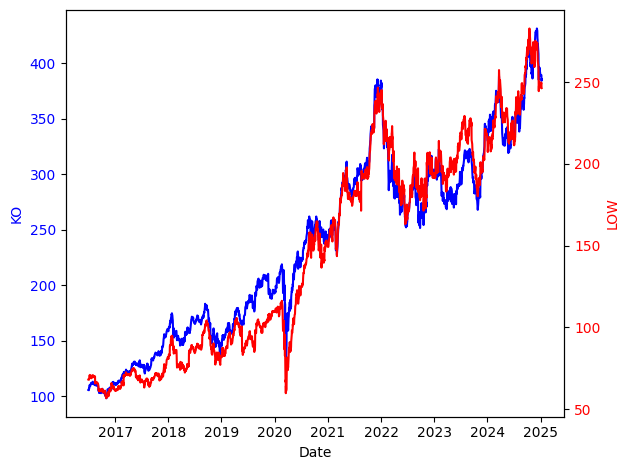

In [1278]:
fig, ax1 = plt.subplots()

# Tracé de la première série (axe de gauche)
ax1.plot(data_.index, data_['HD'], color="blue", label="Cours 1")
ax1.set_xlabel("Date")
ax1.set_ylabel("KO", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Création du deuxième axe (twinx)
ax2 = ax1.twinx()
ax2.plot(data_.index, data_['LOW'], color="red", label="Cours 2")
ax2.set_ylabel("LOW", color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()

plt.show()

Graphiquement, la forme des cours des deux actifs se ressemblement énormément, ce qui semble déjà indiquer une potentielle cointégration. Pour en être certain, nous pouvons utiliser la fonction *coint* de *statsmodels.tsa.stattools* qui renvoie le score ainsi que la pvalue (à la manière de la fonction *pearsonr*).

In [1279]:
score, p_value, _ = coint(data_['HD'], data_['LOW'])

print(f'p-value: {p_value.round(4)}')
print("Les series sont bien cointégrées.") if p_value < 0.05 else print("Les séries ne sont pas cointégrées.")

p-value: 0.048
Les series sont bien cointégrées.


La pvalue est bien inférieure à 5%, ce qui confirme la validité de notre intuition graphique et donc la présence d'une relation de cointégration.

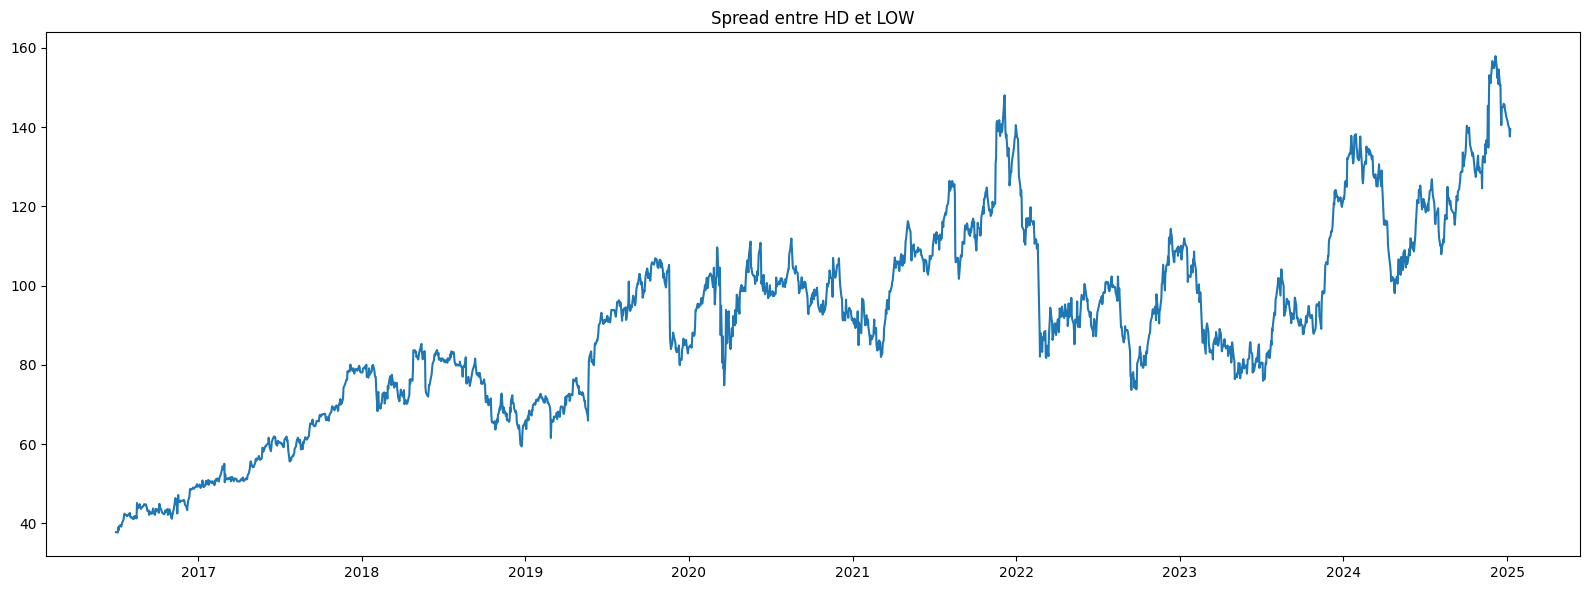

In [1280]:
data_['Spread'] = data_['HD'] - data_['LOW']

plt.figure(figsize=(16, 6))
plt.plot(data_.index, data_['Spread'])
plt.title('Spread entre HD et LOW')
plt.tight_layout()
plt.show()

Nous pouvons maintenant déterminer le **Z-score** du spread. Il s'agit d'une mesure statistique qui indique à quel point une valeur est éloignée de sa moyene. Son calcul est le suivant : $Z = \frac{X - \mu}{\sigma}$. C'est à partir de cet indicateur normalisé que nous émettrons nos signaux d'investissement.

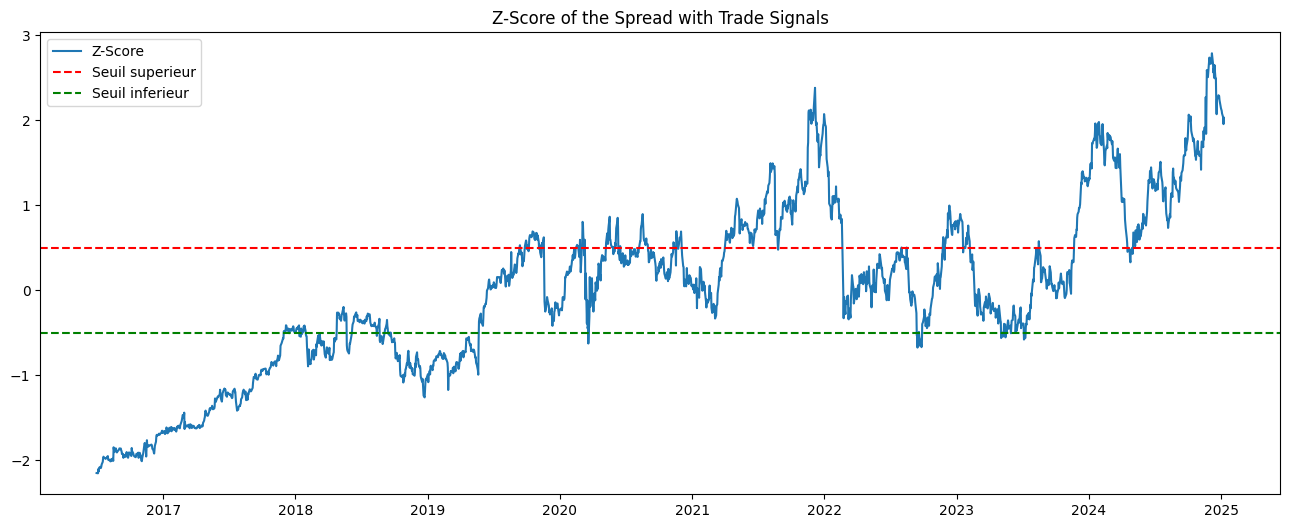

In [1281]:
data_['Z-Score'] = (data_['Spread'] - data_['Spread'].mean()) / data_['Spread'].std()

#Définition des bornes : plus elles sont proches de 0, plus on aura de signaux
borne_sup = 0.5
borne_inf = -0.5

# Initialisation de la colonne des positions
data_['actions'] = 0

# Définition des signaux
data_['actions'] = np.where(data_['Z-Score'] > borne_sup, -1, data_['actions'])  # Short spread
data_['actions'] = np.where(data_['Z-Score'] < borne_inf, 1, data_['actions'])   # Long spread
data_['actions'] = np.where((data_['Z-Score'] < 1) & (data_['Z-Score'] > -1), 0, data_['actions'])  


plt.figure(figsize=(16, 6))
plt.plot(data_.index, data_['Z-Score'], label='Z-Score')
plt.axhline(borne_sup, color='red', linestyle='--', label='Seuil superieur')
plt.axhline(borne_inf, color='green', linestyle='--', label='Seuil inferieur')
plt.legend()
plt.title('Z-Score of the Spread with Trade Signals')
plt.show()

Lorsque que le Z-score vient dépasser la borne supérieure, on vend le spread : on achète LOW et on vend HD. Tandis que s'il passe sous la borne supérieure, on fait l'inverse. En effet, on considère que le spread va revenir vers sa moyenne historique une fois qu'il s'est écarté de celle-ci.

In [1282]:
# Initialisation de la variable de position sur le spread sur None
long=None

# Initialisation de la liste des signaux de chaque actif
inv1=[]
inv2=[]

#Evite differents bugs
inv1.append('HOLD')
inv1.append('HOLD')
inv2.append('HOLD')
inv2.append('HOLD')


for i in range(2,len(data_)):
    if data_['Z-Score'].iloc[i] > borne_sup and long is not True: #On ne peut pas 'acheter le spread' si on est déjà long dessus
        inv1.append('SELL')
        inv2.append('BUY')
        long=True
    elif data_['Z-Score'].iloc[i] < borne_inf and long is not False: #On ne peut pas 'vendre le spread à découvert' si on est déjà short dessus
        inv1.append('BUY')
        inv2.append('SELL')
        long=False
    else:
        inv1.append('HOLD')
        inv2.append('HOLD')

inv1=pd.Series(inv1,index=data_['Z-Score'].index).shift(1) #On décale d'un jour pour lagger les signaux (on dispose des prix close)
inv2=pd.Series(inv2,index=data_['Z-Score'].index).shift(1)

Finalement, il ne reste plus qu'à calculer les rendements de chaque actif puis de les agréger pour obtenir le rendement de la stratégie.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


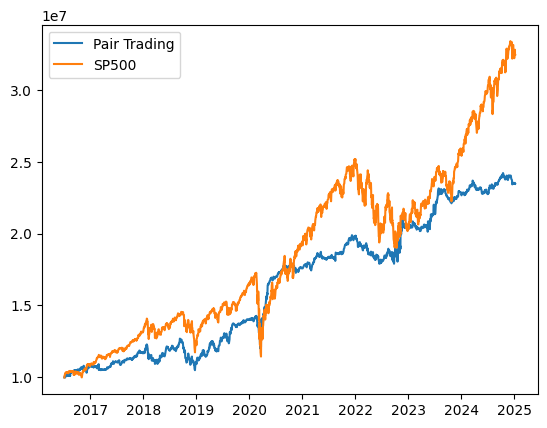

In [1283]:
ticker='HD'
titre_a = yf.download('HD', start='2016-07-06')['Adj Close']
gain_a=profit_actif(titre_a,inv1,cap_actif)

ticker='LOW'
titre_b= yf.download('LOW', start='2016-07-06')['Adj Close']
gain_b=profit_actif(titre_b,inv2,cap_actif)

gain_pairtrading=gain_a+gain_b

benchmark=yf.download('SPY',start='2016-07-06')['Adj Close']

rdmt_spy=benchmark.pct_change().dropna()
rdmt_spy_cumul=np.cumprod(1+rdmt_spy)
spy=rdmt_spy_cumul*(capital)

plt.plot(gain_pairtrading,label='Pair Trading')
plt.plot(spy,label='SP500')
plt.legend()


Cette stratégie ne surperforme pas le benchmark à ce stade. Toutefois, le pair trading repose sur l'hypothèse que le spread reviendra vers sa moyenne historique. Selon les analyses précédentes, le spread est actuellement bien au-delà de cette moyenne, ce qui suggère que la stratégie pourrait générer des profits plus importants lorsque ce mécanisme de recentrage se déclenchera. Le principal défi réside alors dans l'incertitude quant au moment exact de cette correction du spread. Tant que ce recentrage ne se produit pas, il est nécessaire de supporter les pertes latentes, un risque que l'on a vu mettre en difficulté de nombreux fonds comme notamment LTCM.

In [1284]:
PT=analyse(gain_pairtrading,rf,benchmark)
SPY=analyse(spy,rf,benchmark)
PT.add(SPY,fill_value=0).round(4)

,Sharpe,Sortino,Calmar,VaR,cVaR,surplus dégagé
SPY,0.9384,1.1135,0.601,-0.0169,-0.0279,0.000000e+00
capital,0.9660,1.3022,0.792,-0.0095,-0.0164,-8.948787e+06


La stratégie, bien qu'elle demeure moins performante qu'un investissement passif dans le S&P 500 en termes de rendement brut, présente des atouts significatifs. En effet, sa VaR et l'ensemble de ses ratios de performance surpassent non seulement ceux des stratégies basées sur l'analyse technique **mais également ceux du benchmark lui-même**. Cela met en évidence une gestion des risques plus efficace et une performance ajustée au risque nettement supérieure. 

Néanmoins, nous n'avons testé cette stratégie qu'une seule fois et il serait intéressant de s'y intéresser plus profondément afin d’évaluer pleinement son potentiel et sa robustesse.